In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import PPO, DDPG, A2C, TD3
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
data.shape
# delete the first column and the last column
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 4)

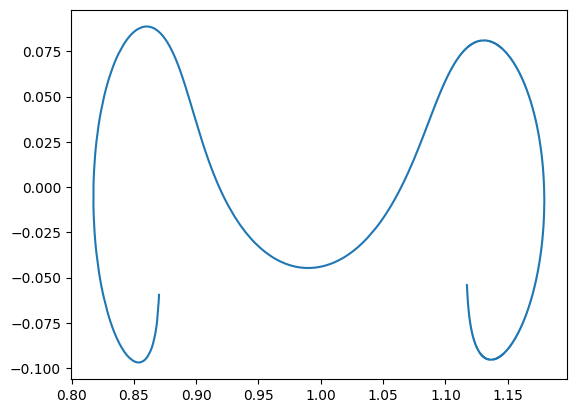

In [3]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [4]:
# three body problem env

class three_body_env(gym.Env):
    def __init__(self, trajectory):
        self.trajectory = trajectory
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-200, high=200, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-100, high=100, shape=(4,), dtype=np.float32)
        self.position = trajectory[0]
        self.steps = 0
        self.max_steps = 1000
        self.reward_range = (-float('inf'), float('inf'))
        self.position_arg = 0
        self.last_position_arg = 0
        self.index_counter = 0
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        a_x = action[0]
        a_y = action[1]

        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x/10
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*(y)/(r2**3) + a_y/10

        x = x + xdot*self.dt
        y = y + ydot*self.dt

        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        # find the closest point in the trajectory
        self.position_arg = np.argmin(np.linalg.norm(self.trajectory - self.position, axis=1))
        # if the agent is not moving, give a negative reward
        if self.position_arg == self.last_position_arg:
            reward = -1
        elif self.position_arg > self.last_position_arg:
            reward = 1
        else:
            reward = -10

        # add reward if the agent is closer to the trajectory 
        error = np.linalg.norm(self.trajectory[self.position_arg] - self.position)
        reward += 1/error
        # if the agent is out of the trajectory, give a negative reward
        if self.position_arg == 0:
            reward = -100
            done = True
        else:
            done = False

        if self.steps > self.max_steps:
            done = True

        return self.position, reward, done, {}

    def reset(self):
        self.steps = 0
        self.position = self.trajectory[0]
        self.position_arg = 0
        self.last_position_arg = 0
        return self.position

    def render(self, mode='human'):
        pass

    def close(self):
        pass

    def seed(self, seed=None):
        pass

In [21]:
env = three_body_env(trajectory)
# Create a TD3 agent
model = TD3('MlpPolicy', env)

/Users/Ali/Documents/BAI/Master/reinforcement-learning/.env/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [22]:
# learn model with show log
model.learn(total_timesteps=10000, reset_num_timesteps=False, tb_log_name="TD3", log_interval=10)
# save model
model.save("td3_three_body")

In [23]:
# test trained model
# save states
position = np.zeros((1000, 4))
env = three_body_env(trajectory)
obs = env.reset()
action_ = []
for i in range(1000):
  action, _states = model.predict(obs, deterministic=True)
  obs, rewards, dones, info = env.step(action)
  position[i] = env.position
  action_.append(action)
  env.render()
  if dones:
    obs = env.reset()

env.close()

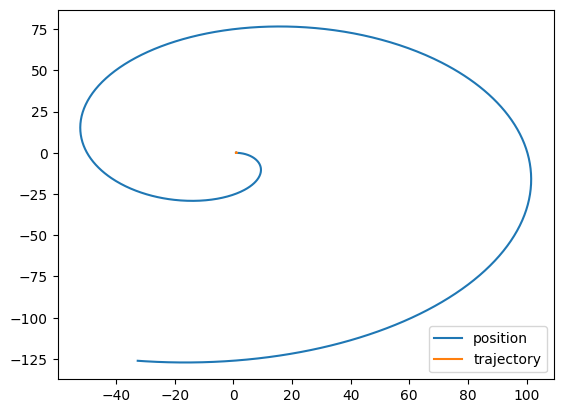

In [25]:
# plot position
plt.plot(position[:,0], position[:,1])
plt.plot(trajectory[:,0], trajectory[:,1])
plt.legend(['position', 'trajectory'])
plt.show()